In [90]:
from collections import deque
from graphviz import Digraph
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import sklearn as sk


In [91]:
class Node:
    def __init__(self, model=None, value=None):
        self.model = model
        self.value = value
        self.left = None
        self.right = None

class TreeDecision:
    def __init__(self):
        self.root = None

    def insert(self, data, model=None):
        if self.root is None:
            self.root = Node(model=model, value=data)
        else:
            self._insert_recursive(self.root, data, model)

    def _insert_recursive(self, current_node, data, model):
        if data < current_node.value:
            if current_node.left is None:
                current_node.left = Node(model=model, value=data)
            else:
                self._insert_recursive(current_node.left, data, model)
        else:
            if current_node.right is None:
                current_node.right = Node(model=model, value=data)
            else:
                self._insert_recursive(current_node.right, data, model)
    def insert_leaf_model(self, model, value):
        def _insert_leaf(node, model, value):
            if value < node.value:
                if node.left is None:
                    node.left = Node(model=model, value='<' + str(node.value))
                else:
                    _insert_leaf(node.left, model, value)
            else:
                if node.right is None:
                    node.right = Node(model=model, value='>=' + str(node.value))
                else:
                    _insert_leaf(node.right, model, value)

        if self.root is not None:
            _insert_leaf(self.root, model, value)
    def train_structure_decomposition(self,data_frame):
        features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
        def train_leaf_model(node, df):
            if node is None:
                return
            if node.left is None and node.right is None:
                if len(df) == 0:
                    return
                X = df[features]
                y = df['total_sold']
                X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.33)
                model = XGBRegressor(n_parameters=200)
                model.fit(X_train, y_train)
                node.model = model
            else:
                # Internal node: split and continue
                try:
                    threshold = float(node.value)
                    left_df = df[df['price_ori'] < threshold]
                    right_df = df[df['price_ori'] >= threshold]
                    train_leaf_model(node.left, left_df)
                    train_leaf_model(node.right, right_df)
                except ValueError:
                    return

        if self.root is not None:
            train_leaf_model(self.root, data_frame)
        
    def prediction(self,df):
        predictions = []
        def choosing_model(node,df):
            if node is None or len(df) == 0:
                return
            if node.left is None and node.right is None:
            # Leaf node: make predictions and store with index
                y_pred = node.model.predict(df)
                result_df = pd.DataFrame({
                    'index': df.index,
                    'prediction': y_pred
                })
                predictions.append(result_df)
            else:
                # Internal node: split and continue
                try:
                    threshold = float(node.value)
                    left_df = df[df['price_ori'] < threshold]
                    right_df = df[df['price_ori'] >= threshold]
                    choosing_model(node.left, left_df)
                    choosing_model(node.right, right_df)
                except ValueError:
                    return
        if self.root is not None:
            choosing_model(self.root, df)
        if predictions:
            # Combine all predictions and sort by original index
            final_df = pd.concat(predictions).set_index('index')
            return final_df
        else:
            return pd.DataFrame(columns=['prediction'])
        
    




In [92]:
TreeDecision=TreeDecision()
df=pd.read_csv("fashion_data_set.csv")
df['discount']=100*(1.-df['price_actual']/df['price_ori'])
TreeDecision.insert(data=1000)
TreeDecision.insert(data=500)
TreeDecision.insert(data=250)
TreeDecision.insert(data=150)
TreeDecision.insert(data=0)
TreeDecision.insert(data=200)
TreeDecision.insert(data=150.1)
TreeDecision.insert(data=249.9)
TreeDecision.insert(data=300)
TreeDecision.insert(data=250.1)
TreeDecision.insert(data=499.99)
TreeDecision.insert(data=999.9)
TreeDecision.insert(data=2500)
TreeDecision.insert(data=1500)

TreeDecision.insert(data=10000)
TreeDecision.insert(data=2499.9)
TreeDecision.insert(data=1000.1)



TreeDecision.train_structure_decomposition(data_frame=df)


c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_parameters" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_parameters" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_parameters" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:23] WARN

In [93]:
features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
X = df.loc[df['price_ori']<100,features]
y = df.loc[df['price_ori']<100,'total_sold']
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.8,random_state=101)

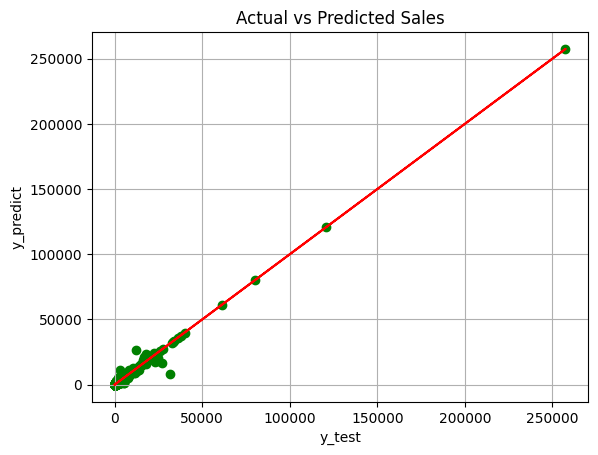

In [94]:
y_predict=TreeDecision.prediction(X_test)
import matplotlib.pyplot as plt
fig=plt.figure()
plt.scatter(y_test, y_predict, color='green')
plt.plot(y_test, y_test, color='red')
plt.xlabel('y_test')
plt.ylabel('y_predict')
plt.title('Actual vs Predicted Sales')
plt.grid(True)
plt.show()

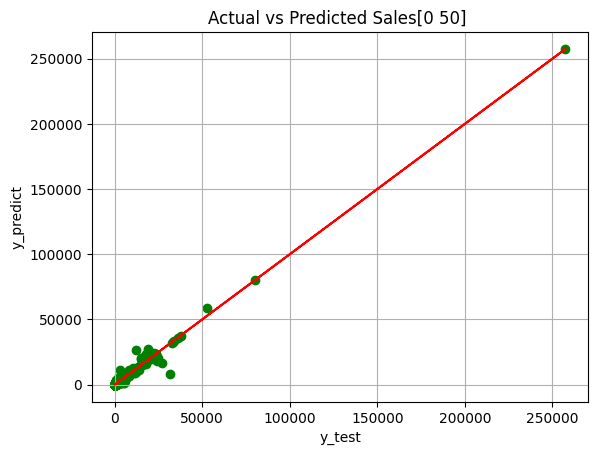

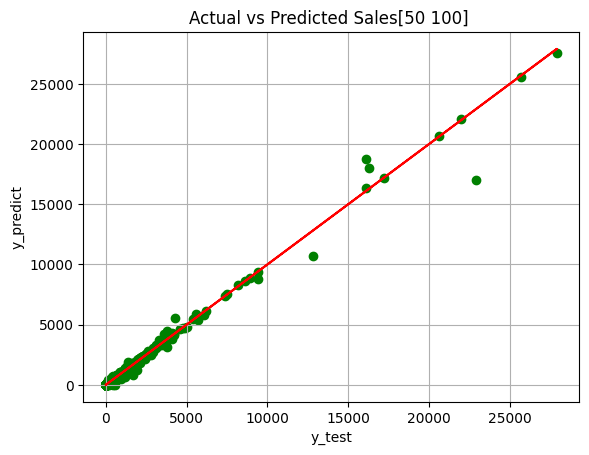

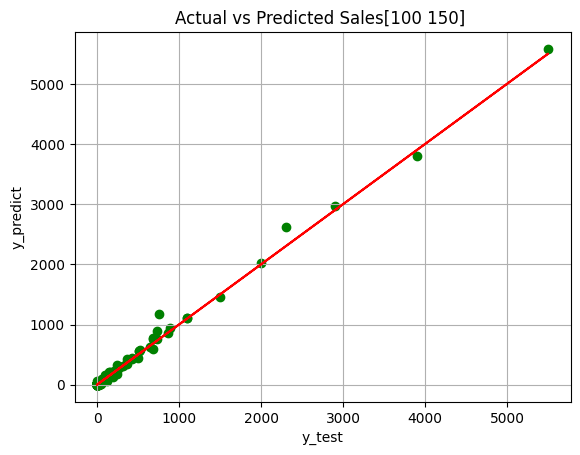

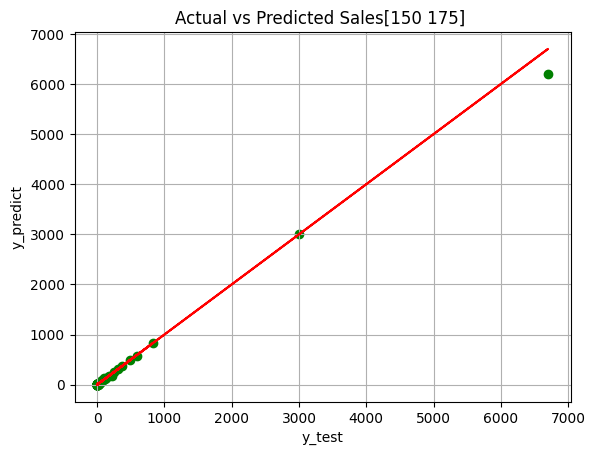

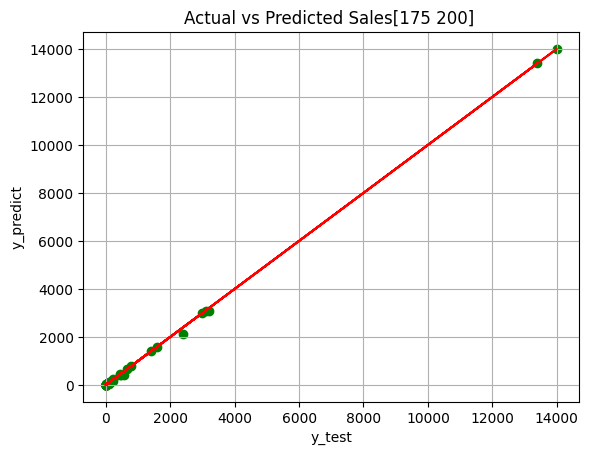

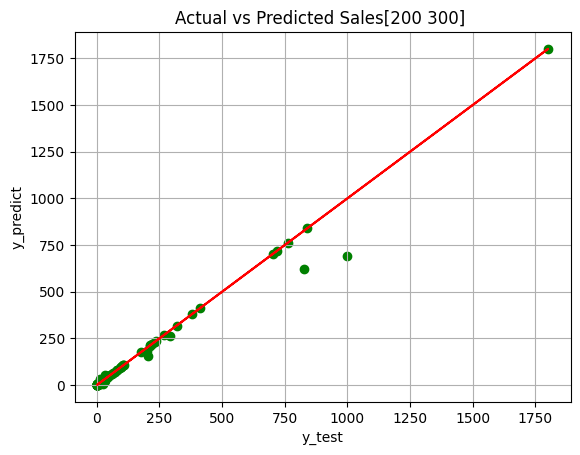

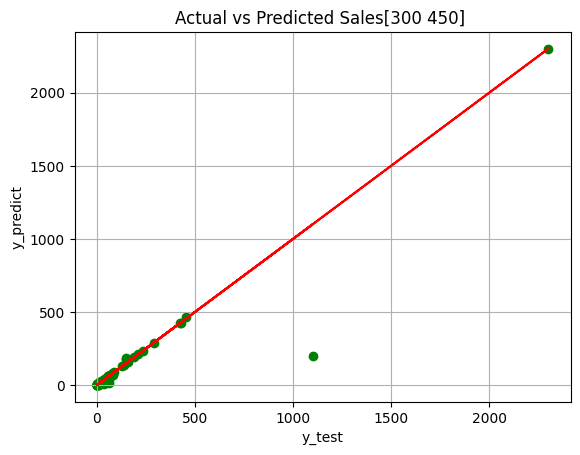

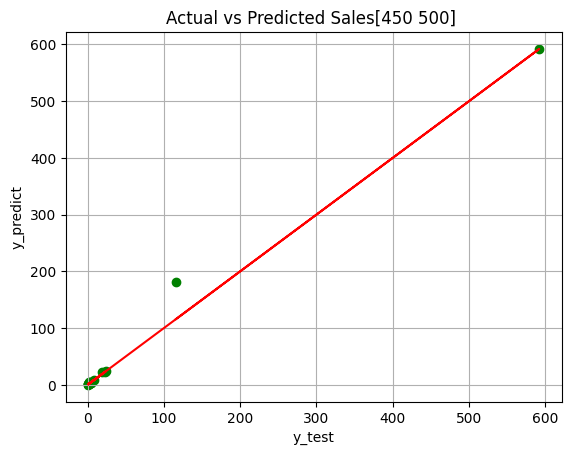

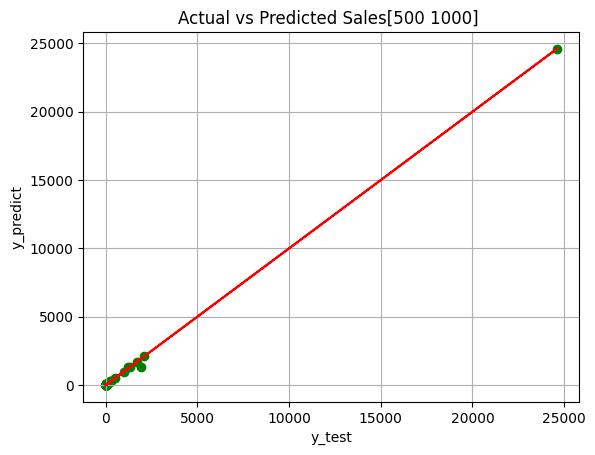

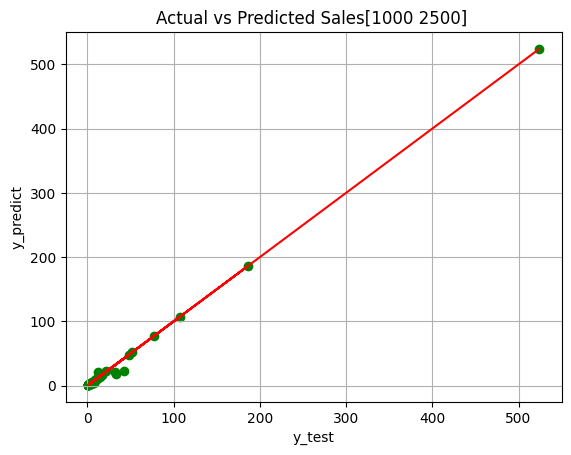

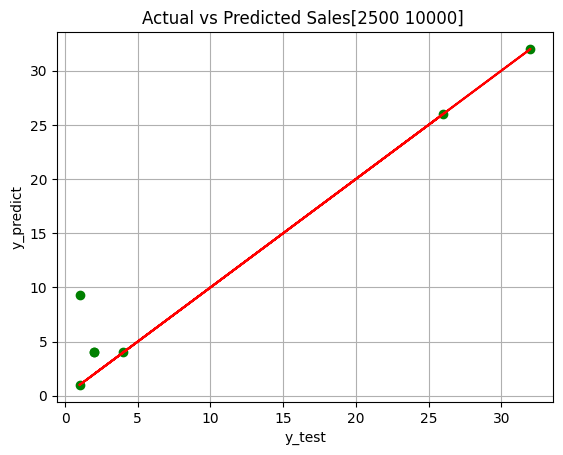

In [95]:
lisup=[50,100,150,175,200,300,450,500,1000,2500,10000]
listdown=[0,50,100,150,175,200,300,450,500,1000,2500]

for i in lisup:
    features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
    X = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]) ,features]
    y = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]),'total_sold']
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.8,random_state=101)
    y_predict=TreeDecision.prediction(X_test)
    fig=plt.figure()
    plt.scatter(y_test.sort_index(), y_predict.sort_index(), color='green')
    plt.plot(y_test.sort_index(), y_test.sort_index(), color='red')
    plt.xlabel('y_test',)
    plt.ylabel('y_predict')
    plt.title('Actual vs Predicted Sales' f'[{listdown[lisup.index(i)]} {i}] ')
    plt.grid(True)
    plt.show()


In [96]:
y_test.sort_index()
y_test.mean()

np.float64(9.714285714285714)

In [97]:
y_predict.sort_index()
y_predict.mean()

prediction    11.476384
dtype: float32

np.float64(3.0479586274479806)

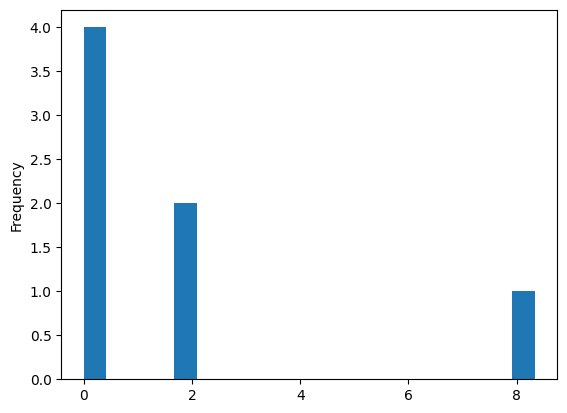

In [98]:
df_diff=y_predict.sort_index()['prediction']-y_test.sort_index()
df_diff.plot(kind='hist',bins=20)
df_diff.std()

In [99]:
def visualize_tree(tree):
    dot = Digraph()

    def add_nodes_edges(node, parent_id=None):
        if node is None:
            return
        node_id = str(id(node))
        label = f'{node.value}\n{node.model}' if node.model else str(node.value)
        dot.node(node_id, label)
        if parent_id:
            dot.edge(parent_id, node_id)
        add_nodes_edges(node.left, node_id)
        add_nodes_edges(node.right, node_id)

    add_nodes_edges(tree.root)
    return dot
dot = visualize_tree(TreeDecision)
dot.render('tree', view=True)


'''
def visualize_tree(node):
    dot = Digraph()
    
    def add_nodes_edges(node, parent_id=None):
        if node is None:
            return
        node_id = str(id(node))
        dot.node(node_id, str(node.value),str(node.model))
        if parent_id:
            dot.edge(parent_id, node_id)
        add_nodes_edges(node.left, node_id)
        add_nodes_edges(node.right, node_id)

    add_nodes_edges(node)
    return dot
dot = visualize_tree(TreeDecision.root)
dot.render('tree', view=True) 
'''

"\ndef visualize_tree(node):\n    dot = Digraph()\n    \n    def add_nodes_edges(node, parent_id=None):\n        if node is None:\n            return\n        node_id = str(id(node))\n        dot.node(node_id, str(node.value),str(node.model))\n        if parent_id:\n            dot.edge(parent_id, node_id)\n        add_nodes_edges(node.left, node_id)\n        add_nodes_edges(node.right, node_id)\n\n    add_nodes_edges(node)\n    return dot\ndot = visualize_tree(TreeDecision.root)\ndot.render('tree', view=True) \n"

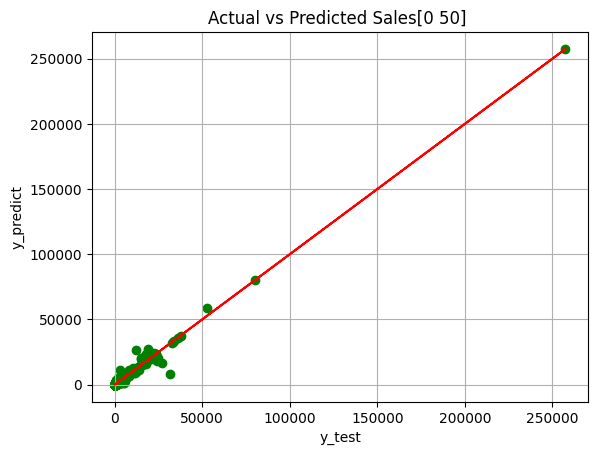

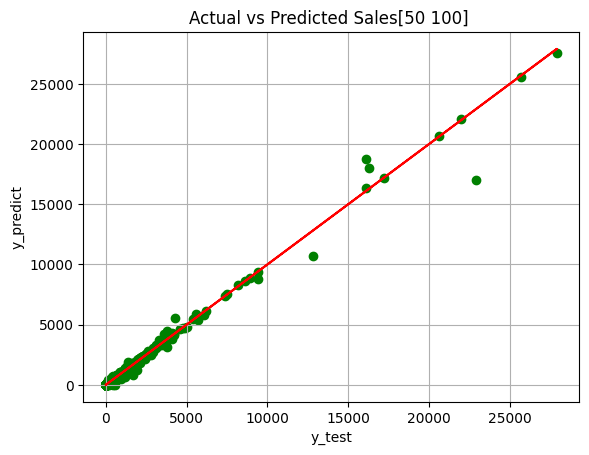

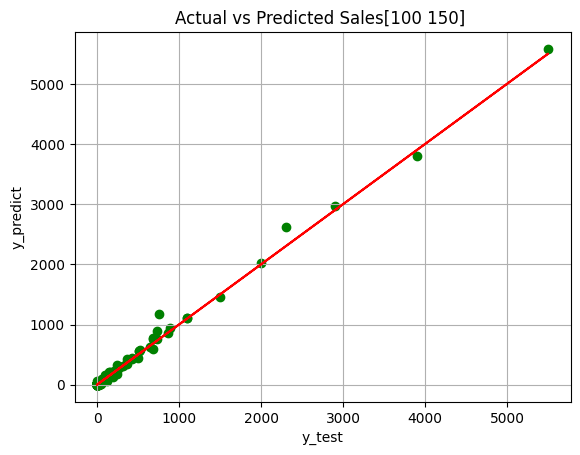

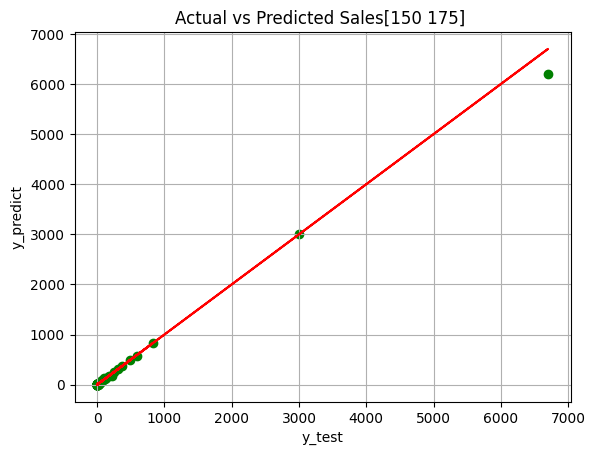

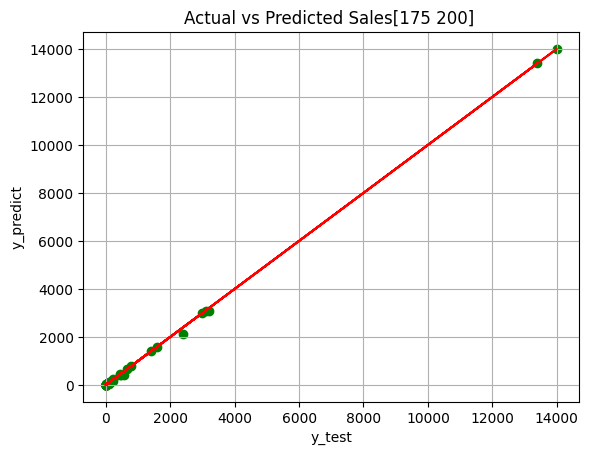

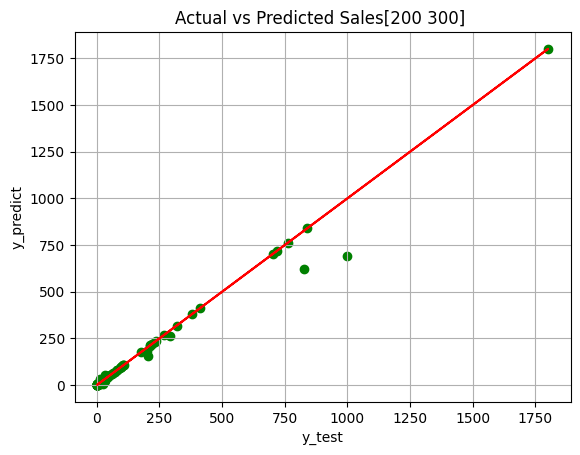

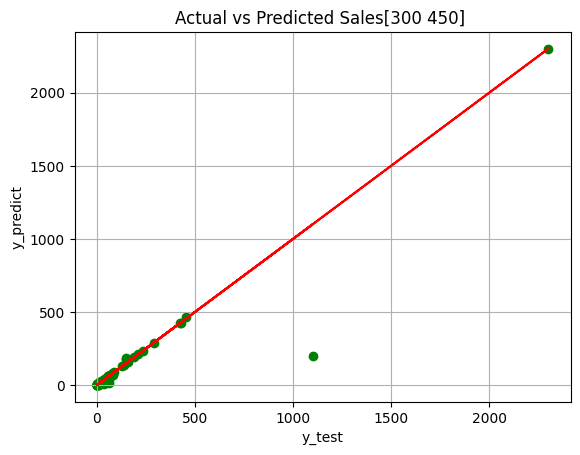

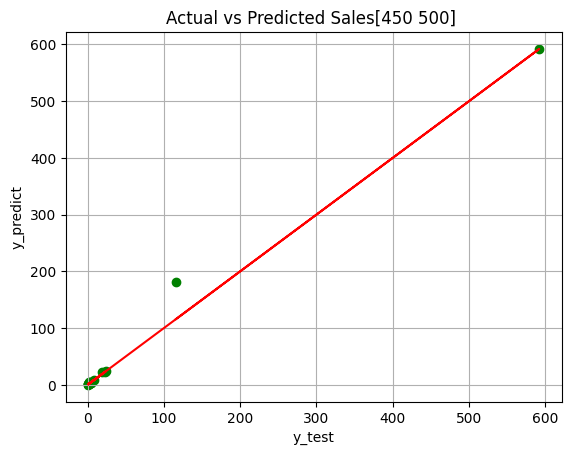

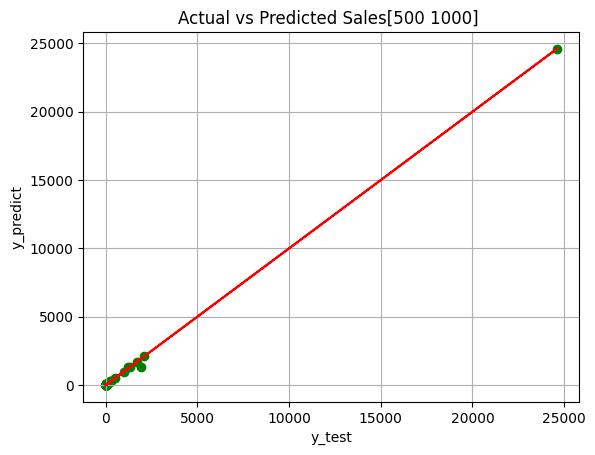

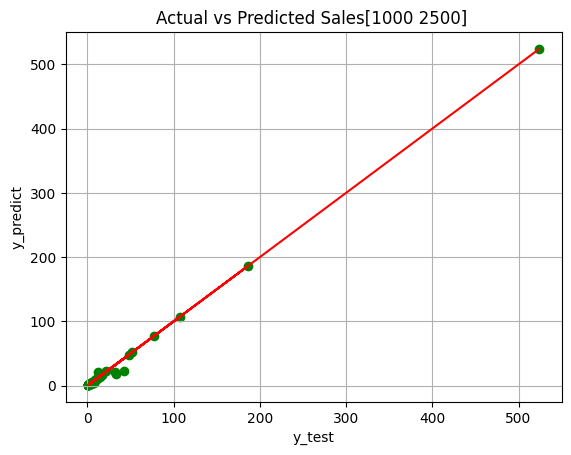

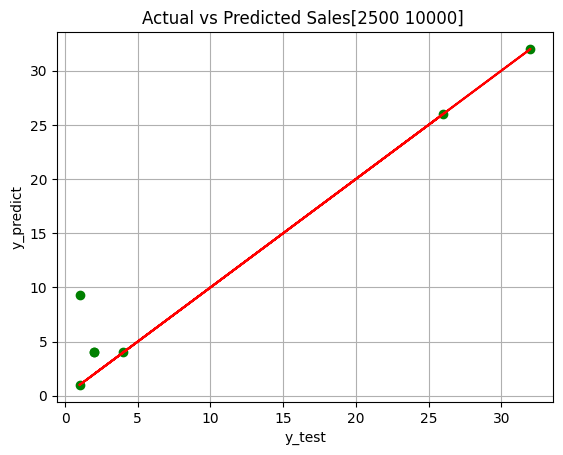

In [100]:
from matplotlib.backends.backend_pdf import PdfPages

lisup=[50,100,150,175,200,300,450,500,1000,2500,10000]
listdown=[0,50,100,150,175,200,300,450,500,1000,2500]


# Create a PDF file to store all figures
with PdfPages("actual_vs_predicted_sales_plots.pdf") as pdf:
    for i in lisup:
        features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
        X = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]) ,features]
        y = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]),'total_sold']
        X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.8,random_state=101)
        y_predict=TreeDecision.prediction(X_test)
        fig=plt.figure()
        plt.scatter(y_test.sort_index(), y_predict.sort_index(), color='green')
        plt.plot(y_test.sort_index(), y_test.sort_index(), color='red')
        plt.xlabel('y_test',)
        plt.ylabel('y_predict')
        plt.title('Actual vs Predicted Sales' f'[{listdown[lisup.index(i)]} {i}] ')
        plt.grid(True)
        plt.show()
        
        pdf.savefig(fig)  # Save the current figure into the PDF
        plt.close(fig)    # Close the figure to free memory


with PCA 

In [101]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
class Node:
    def __init__(self, model=None, value=None):
        self.left = None
        self.right = None
        self.model = model
        self.value = value
        self.scaler = None
        self.pca = None
class TreeDecision_second:
    def __init__(self):
        self.root = None

    def insert(self, data, model=None):
        if self.root is None:
            self.root = Node(model=model, value=data)
        else:
            self._insert_recursive(self.root, data, model)

    def _insert_recursive(self, current_node, data, model):
        if data < current_node.value:
            if current_node.left is None:
                current_node.left = Node(model=model, value=data)
            else:
                self._insert_recursive(current_node.left, data, model)
        else:
            if current_node.right is None:
                current_node.right = Node(model=model, value=data)
            else:
                self._insert_recursive(current_node.right, data, model)
    def insert_leaf_model(self, model, value):
        def _insert_leaf(node, model, value):
            if value < node.value:
                if node.left is None:
                    node.left = Node(model=model, value='<' + str(node.value))
                else:
                    _insert_leaf(node.left, model, value)
            else:
                if node.right is None:
                    node.right = Node(model=model, value='>=' + str(node.value))
                else:
                    _insert_leaf(node.right, model, value)

        if self.root is not None:
            _insert_leaf(self.root, model, value)
    def train_structure_decomposition(self,data_frame):
        features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
        def train_leaf_model(node, df):
            if node is None:
                return
            if node.left is None and node.right is None:
                if len(df) == 0:
                    return
                X = df[features]
                y = df['total_sold']
                X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.33)
                scaler = StandardScaler()
                df_scaled = scaler.fit_transform(X_train)
                pca = PCA(n_components=5)  # Choose number of components
                pca_result = pca.fit_transform(df_scaled)

                # 3. Convert to DataFrame
                df_pca = pd.DataFrame(pca_result)
                df_pca.index = X_train.index
                X_train=df_pca
                model = XGBRegressor(n_parameters=200)
                model.fit(X_train, y_train)
                node.model = model
                node.scaler = scaler
                node.pca = pca
            else:
                # Internal node: split and continue
                try:
                    threshold = float(node.value)
                    left_df = df[df['price_ori'] < threshold]
                    right_df = df[df['price_ori'] >= threshold]
                    train_leaf_model(node.left, left_df)
                    train_leaf_model(node.right, right_df)
                except ValueError:
                    return

        if self.root is not None:
            train_leaf_model(self.root, data_frame)
    
    def prediction(self,df):
        predictions = []
        def choosing_model(node,df):
            if node is None or len(df) == 0:
                return
            if node.left is None and node.right is None:
                df_scaled = node.scaler.transform(df)
                df_pca = node.pca.transform(df_scaled)
                df_pca = pd.DataFrame(df_pca, index=df.index)
                    
                y_pred = node.model.predict(df_pca)
                result_df = pd.DataFrame({
                    'index': df.index,
                    'prediction': y_pred
                })
                predictions.append(result_df)
            else:
                # Internal node: split and continue
                try:
                    threshold = float(node.value)
                    left_df = df[df['price_ori'] < threshold]
                    right_df = df[df['price_ori'] >= threshold]
                    choosing_model(node.left, left_df)
                    choosing_model(node.right, right_df)
                except ValueError:
                    return
        if self.root is not None:
            choosing_model(self.root, df)
        if predictions:
            # Combine all predictions and sort by original index
            final_df = pd.concat(predictions).set_index('index')
            return final_df
        else:
            return pd.DataFrame(columns=['prediction'])
    

             
        
    

TreeDecision_2=TreeDecision_second()
df=pd.read_csv("fashion_data_set.csv")
df['discount']=100*(1.-df['price_actual']/df['price_ori'])
TreeDecision_2.insert(data=1000)
TreeDecision_2.insert(data=500)
TreeDecision_2.insert(data=250)
TreeDecision_2.insert(data=150)
TreeDecision_2.insert(data=0)
TreeDecision_2.insert(data=200)
TreeDecision_2.insert(data=150.1)
TreeDecision_2.insert(data=249.9)
TreeDecision_2.insert(data=300)
TreeDecision_2.insert(data=250.1)
TreeDecision_2.insert(data=499.99)
TreeDecision_2.insert(data=999.9)
TreeDecision_2.insert(data=2500)
TreeDecision_2.insert(data=1500)

TreeDecision_2.insert(data=10000)
TreeDecision_2.insert(data=2499.9)
TreeDecision_2.insert(data=1000.1)




In [102]:

TreeDecision_2.train_structure_decomposition(data_frame=df)
lisup=[50,100,150,175,200,300,450,500,1000,2500,10000]
listdown=[0,50,100,150,175,200,300,450,500,1000,2500]


c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_parameters" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_parameters" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_parameters" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:31] WARN

In [103]:
'''def visualize_tree(tree):
    dot = Digraph()

    def add_nodes_edges(node, parent_id=None):
        if node is None:
            return
        node_id = str(id(node))
        label = f'{node.value}\n{node.model}' if node.model else str(node.value)
        dot.node(node_id, label)
        if parent_id:
            dot.edge(parent_id, node_id)
        add_nodes_edges(node.left, node_id)
        add_nodes_edges(node.right, node_id)

    add_nodes_edges(tree.root)
    return dot
dot = visualize_tree(TreeDecision_2)
dot.render('tree_2', view=True)'''

"def visualize_tree(tree):\n    dot = Digraph()\n\n    def add_nodes_edges(node, parent_id=None):\n        if node is None:\n            return\n        node_id = str(id(node))\n        label = f'{node.value}\n{node.model}' if node.model else str(node.value)\n        dot.node(node_id, label)\n        if parent_id:\n            dot.edge(parent_id, node_id)\n        add_nodes_edges(node.left, node_id)\n        add_nodes_edges(node.right, node_id)\n\n    add_nodes_edges(tree.root)\n    return dot\ndot = visualize_tree(TreeDecision_2)\ndot.render('tree_2', view=True)"

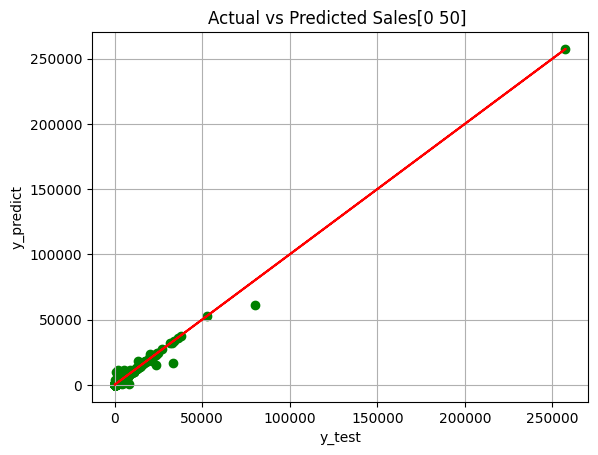

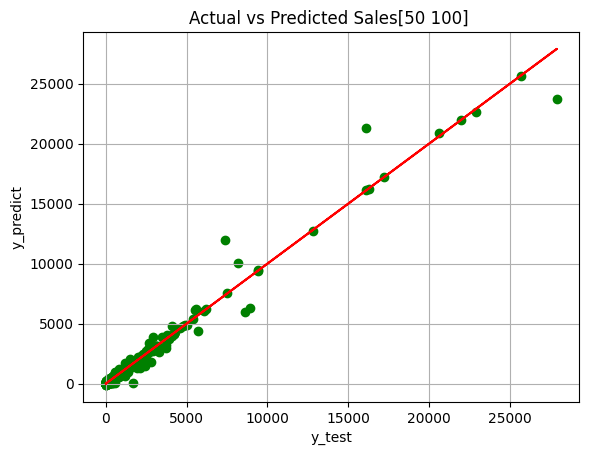

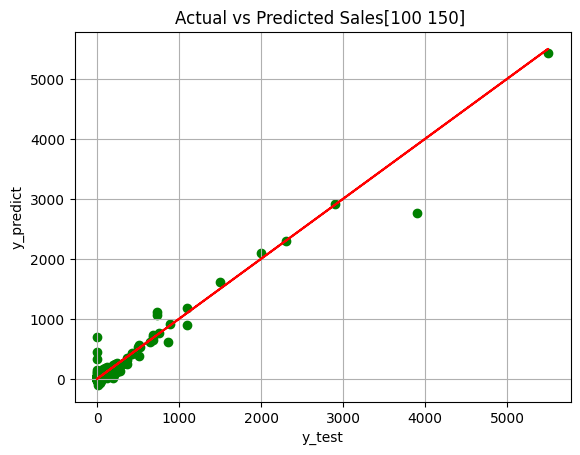

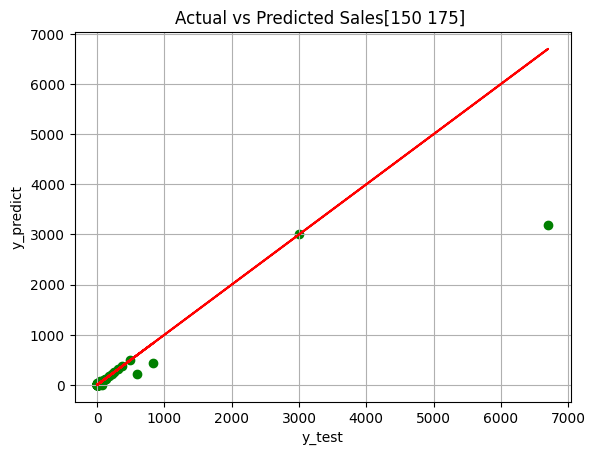

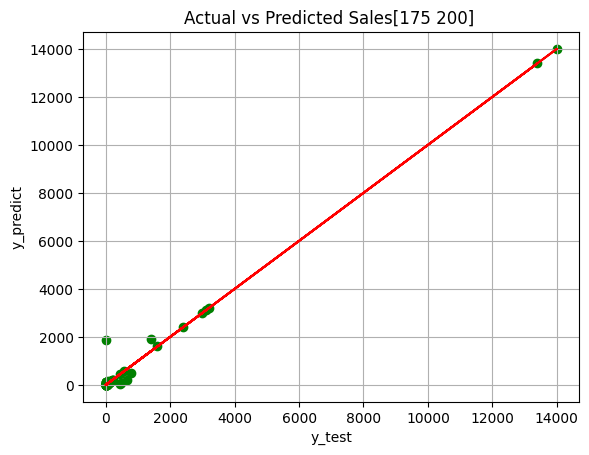

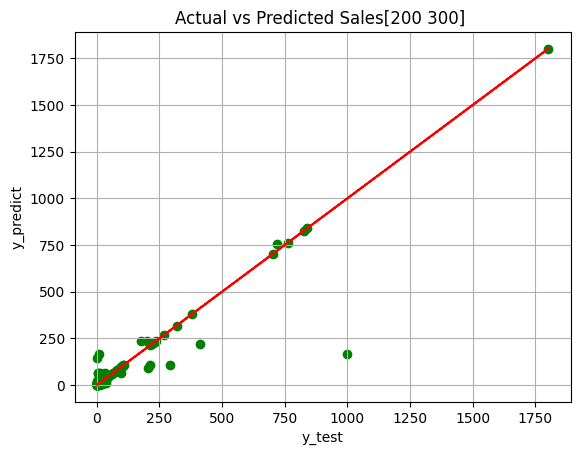

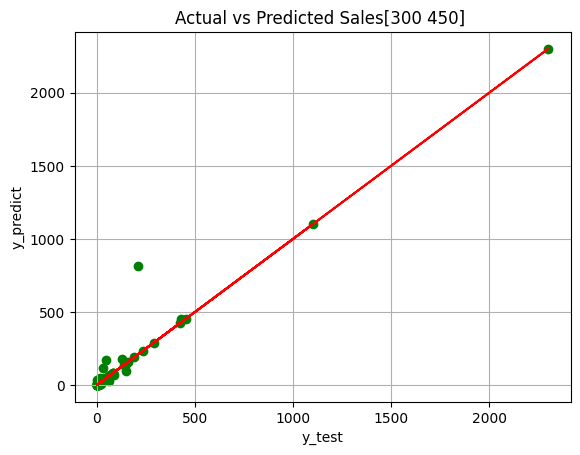

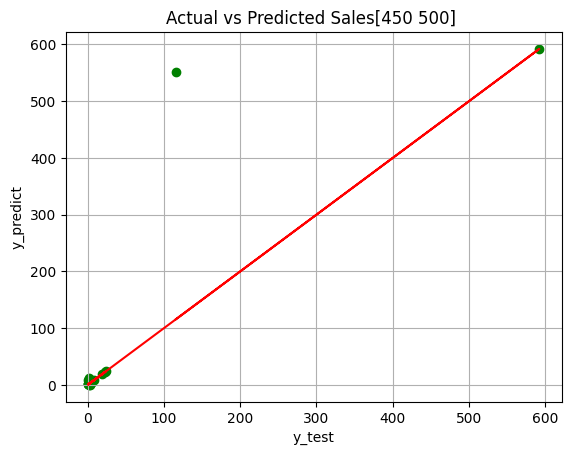

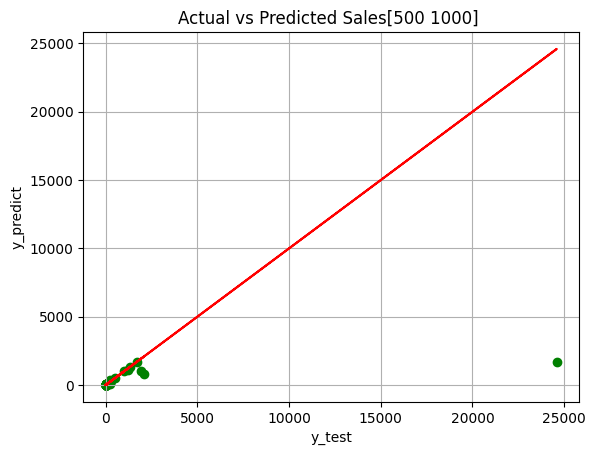

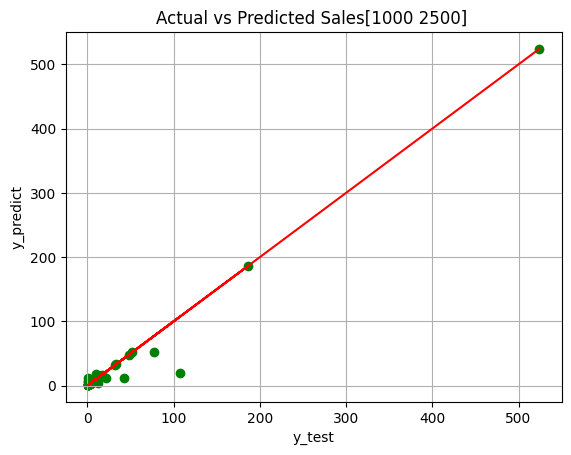

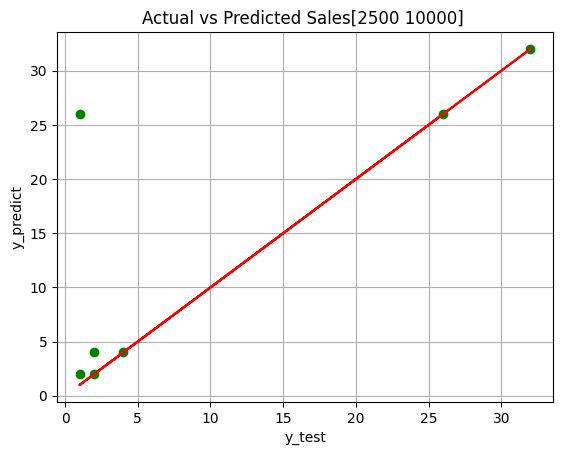

In [104]:
for i in lisup:
    features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
    X = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]) ,features]
    y = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]),'total_sold']
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.8,random_state=101)
    y_predict=TreeDecision_2.prediction(X_test)
    fig=plt.figure()
    plt.scatter(y_test.sort_index(), y_predict.sort_index(), color='green')
    plt.plot(y_test.sort_index(), y_test.sort_index(), color='red')
    plt.xlabel('y_test',)
    plt.ylabel('y_predict')
    plt.title('Actual vs Predicted Sales' f'[{listdown[lisup.index(i)]} {i}] ')
    plt.grid(True)
    plt.show()

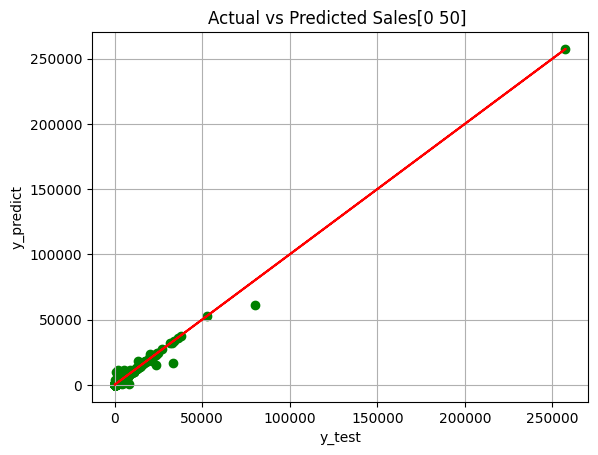

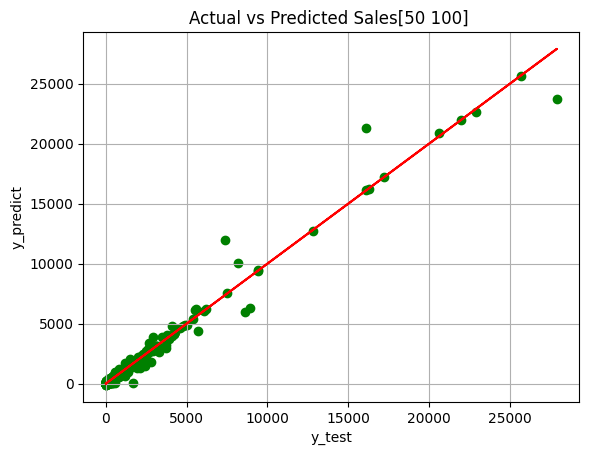

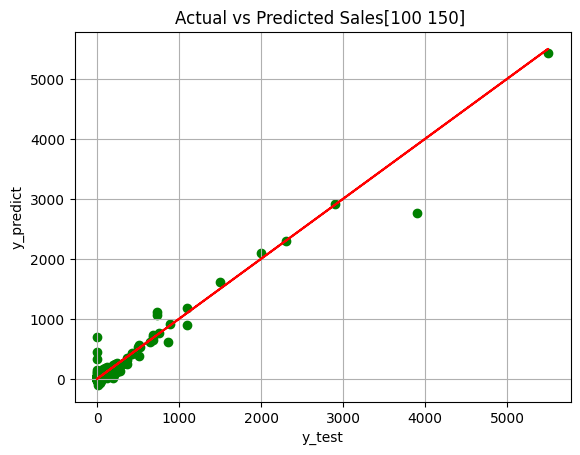

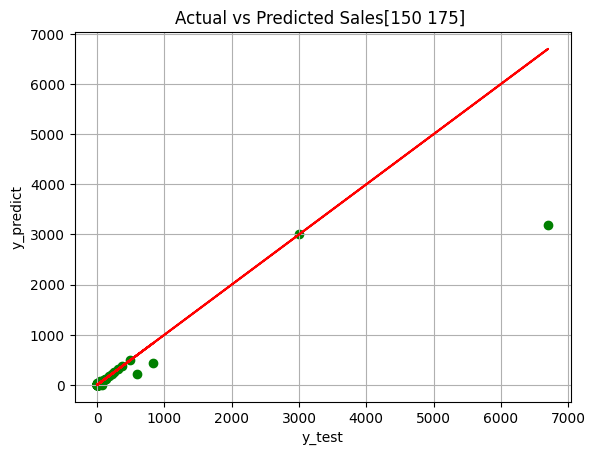

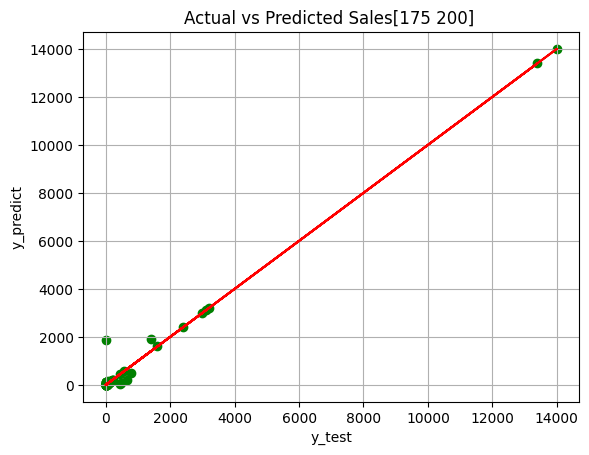

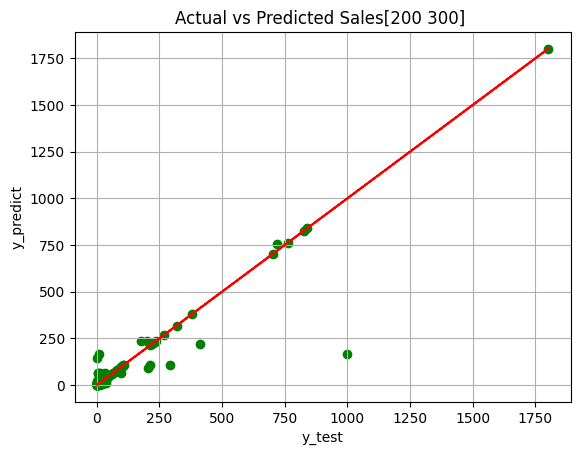

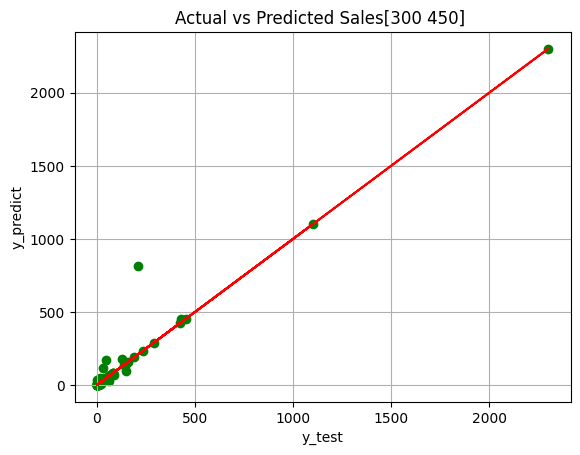

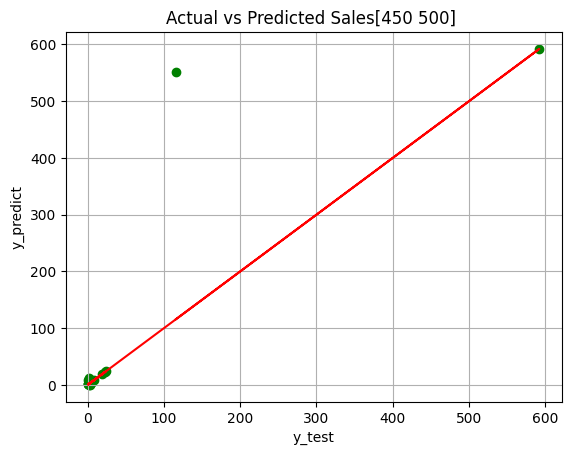

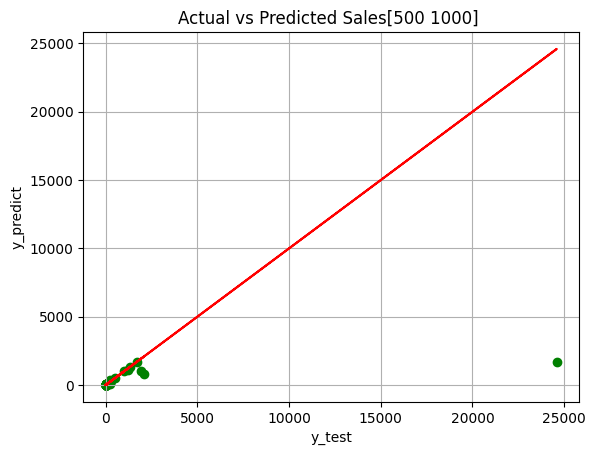

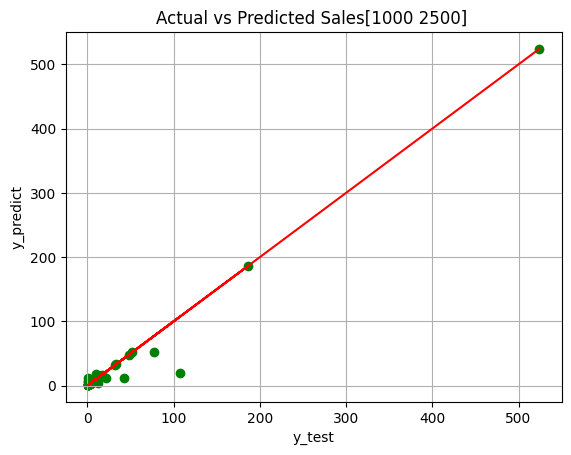

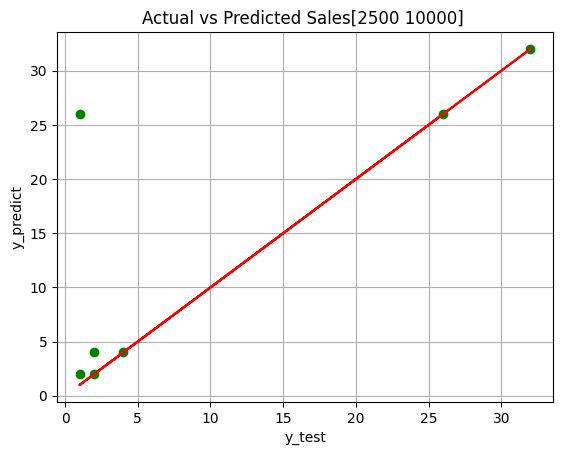

In [105]:

lisup=[50,100,150,175,200,300,450,500,1000,2500,10000]
listdown=[0,50,100,150,175,200,300,450,500,1000,2500]
# Create a PDF file to store all figures
with PdfPages("actual_vs_predicted_sales_plots_PCA.pdf") as pdf:
    for i in lisup:
        features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
        X = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]) ,features]
        y = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]),'total_sold']
        X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.8,random_state=101)
        y_predict=TreeDecision_2.prediction(X_test)
        fig=plt.figure()
        plt.scatter(y_test.sort_index(), y_predict.sort_index(), color='green')
        plt.plot(y_test.sort_index(), y_test.sort_index(), color='red')
        plt.xlabel('y_test',)
        plt.ylabel('y_predict')
        plt.title('Actual vs Predicted Sales' f'[{listdown[lisup.index(i)]} {i}] ')
        plt.grid(True)
        plt.show()
        
        pdf.savefig(fig)  # Save the current figure into the PDF
        plt.close(fig)    # Close the figure to free memory


KPCA GOES BRRRR


c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_parameters" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_parameters" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_parameters" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\wak computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:35:46] WARN

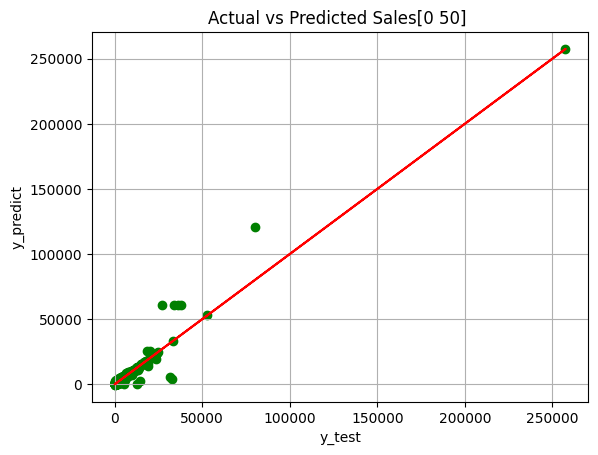

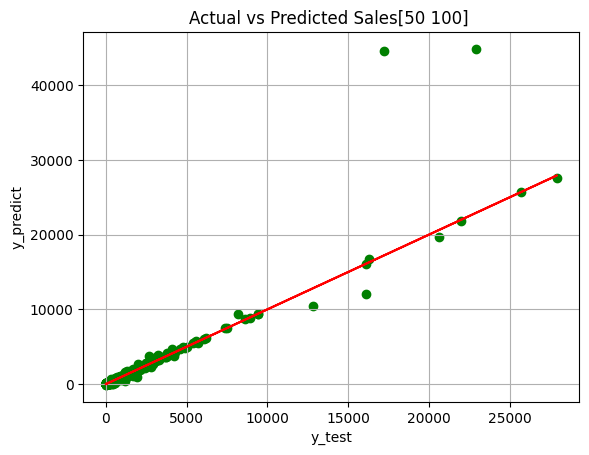

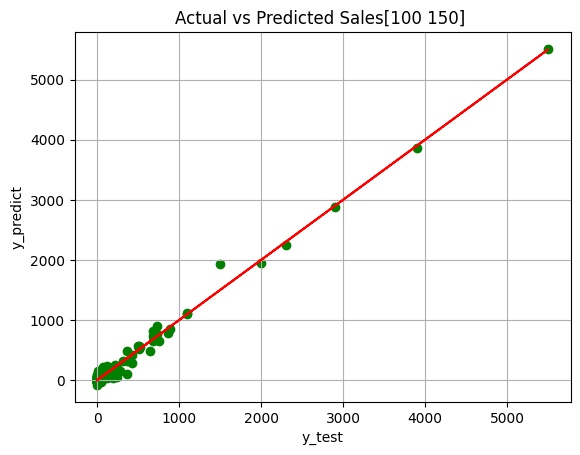

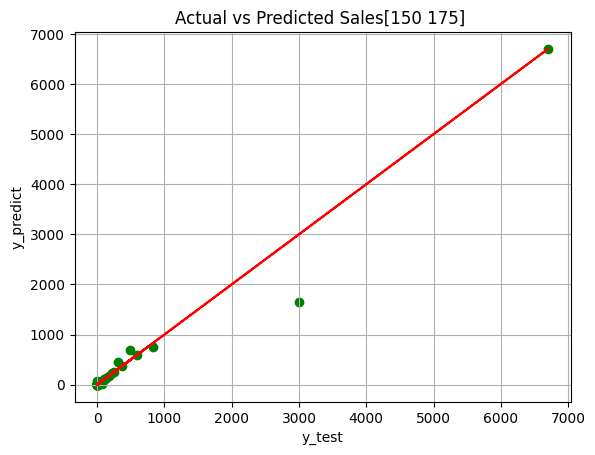

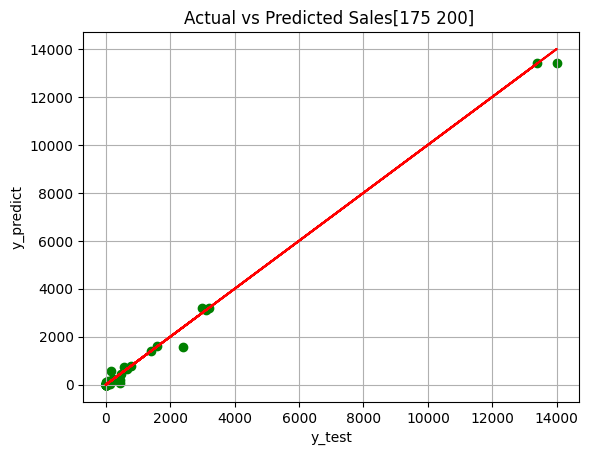

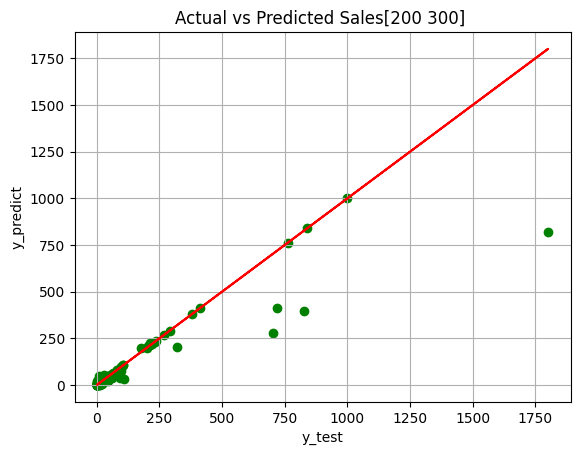

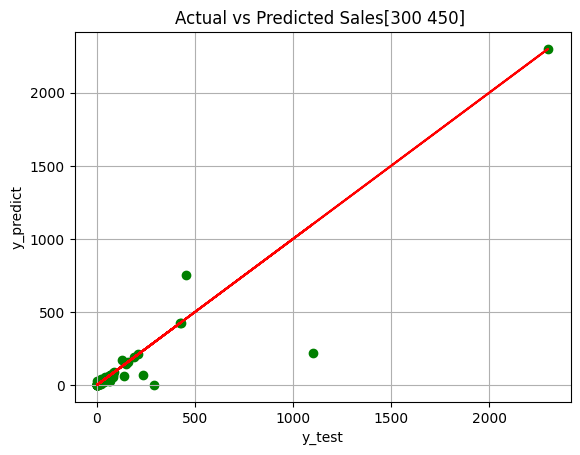

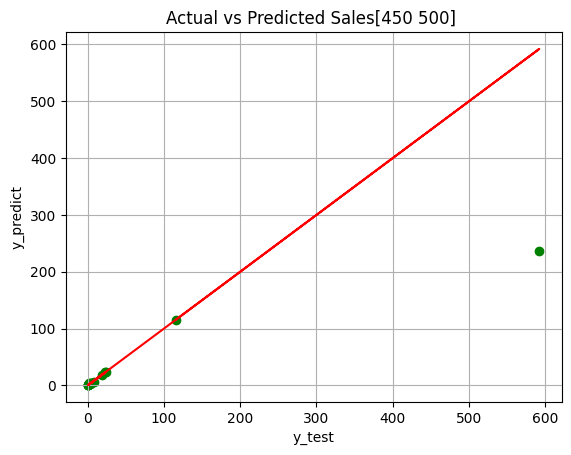

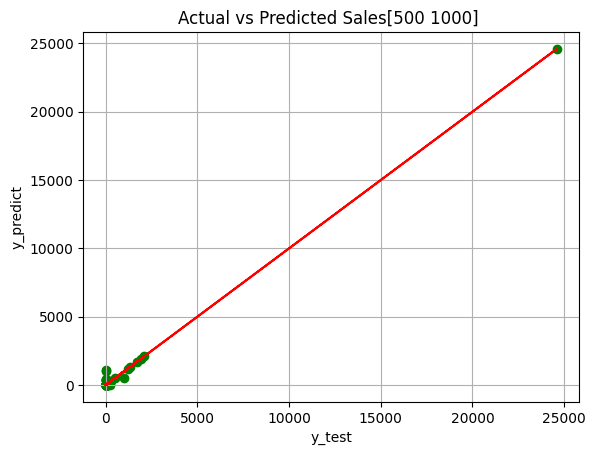

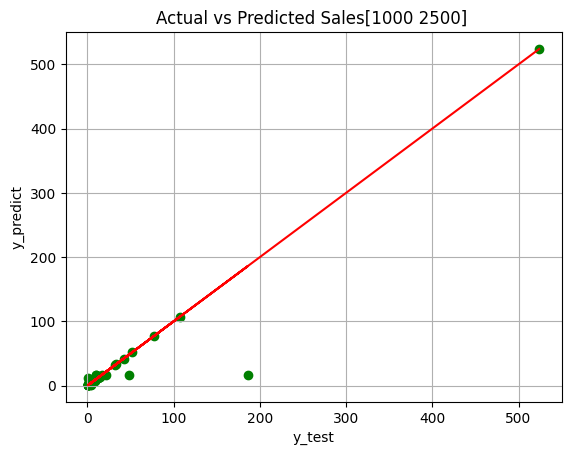

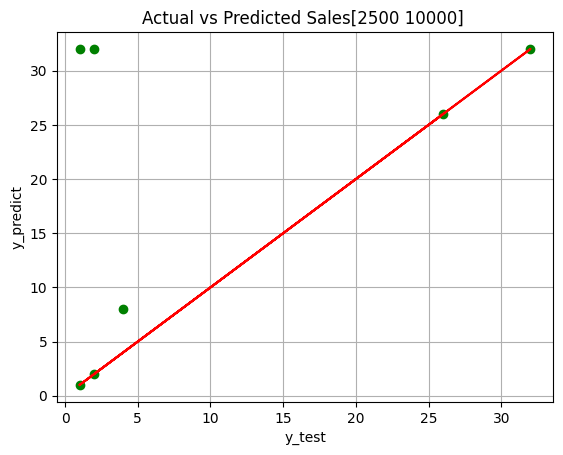

In [106]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sklearn as sk
class Node:
    def __init__(self, model=None, value=None):
        self.left = None
        self.right = None
        self.model = model
        self.value = value
        self.scaler = None
        self.pca = None
class TreeDecision_third:
    def __init__(self):
        self.root = None

    def insert(self, data, model=None):
        if self.root is None:
            self.root = Node(model=model, value=data)
        else:
            self._insert_recursive(self.root, data, model)

    def _insert_recursive(self, current_node, data, model):
        if data < current_node.value:
            if current_node.left is None:
                current_node.left = Node(model=model, value=data)
            else:
                self._insert_recursive(current_node.left, data, model)
        else:
            if current_node.right is None:
                current_node.right = Node(model=model, value=data)
            else:
                self._insert_recursive(current_node.right, data, model)
    def insert_leaf_model(self, model, value):
        def _insert_leaf(node, model, value):
            if value < node.value:
                if node.left is None:
                    node.left = Node(model=model, value='<' + str(node.value))
                else:
                    _insert_leaf(node.left, model, value)
            else:
                if node.right is None:
                    node.right = Node(model=model, value='>=' + str(node.value))
                else:
                    _insert_leaf(node.right, model, value)

        if self.root is not None:
            _insert_leaf(self.root, model, value)
    def train_structure_decomposition(self,data_frame):
        features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
        def train_leaf_model(node, df):
            if node is None:
                return
            if node.left is None and node.right is None:
                if len(df) == 0:
                    return
                X = df[features]
                y = df['total_sold']
                X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.33)
                scaler = StandardScaler()
                df_scaled = scaler.fit_transform(X_train)
                pca = KernelPCA(n_components=5)  # Choose number of components
                pca_result = pca.fit_transform(df_scaled)

                # 3. Convert to DataFrame
                df_pca = pd.DataFrame(pca_result)
                df_pca.index = X_train.index
                X_train=df_pca
                model = XGBRegressor(n_parameters=200)
                model.fit(X_train, y_train)
                node.model = model
                node.scaler = scaler
                node.pca = pca
            else:
                # Internal node: split and continue
                try:
                    threshold = float(node.value)
                    left_df = df[df['price_ori'] < threshold]
                    right_df = df[df['price_ori'] >= threshold]
                    train_leaf_model(node.left, left_df)
                    train_leaf_model(node.right, right_df)
                except ValueError:
                    return

        if self.root is not None:
            train_leaf_model(self.root, data_frame)
    
    def prediction(self,df):
        predictions = []
        def choosing_model(node,df):
            if node is None or len(df) == 0:
                return
            if node.left is None and node.right is None:
                df_scaled = node.scaler.transform(df)
                df_pca = node.pca.transform(df_scaled)
                df_pca = pd.DataFrame(df_pca, index=df.index)
                    
                y_pred = node.model.predict(df_pca)
                result_df = pd.DataFrame({
                    'index': df.index,
                    'prediction': y_pred
                })
                predictions.append(result_df)
            else:
                # Internal node: split and continue
                try:
                    threshold = float(node.value)
                    left_df = df[df['price_ori'] < threshold]
                    right_df = df[df['price_ori'] >= threshold]
                    choosing_model(node.left, left_df)
                    choosing_model(node.right, right_df)
                except ValueError:
                    return
        if self.root is not None:
            choosing_model(self.root, df)
        if predictions:
            # Combine all predictions and sort by original index
            final_df = pd.concat(predictions).set_index('index')
            return final_df
        else:
            return pd.DataFrame(columns=['prediction'])
    

             
        
    

TreeDecision_3=TreeDecision_third()
df=pd.read_csv("fashion_data_set.csv")
df['discount']=100*(1.-df['price_actual']/df['price_ori'])
TreeDecision_3.insert(data=1000)
TreeDecision_3.insert(data=500)
TreeDecision_3.insert(data=250)
TreeDecision_3.insert(data=150)
TreeDecision_3.insert(data=0)
TreeDecision_3.insert(data=200)
TreeDecision_3.insert(data=150.1)
TreeDecision_3.insert(data=249.9)
TreeDecision_3.insert(data=300)
TreeDecision_3.insert(data=250.1)
TreeDecision_3.insert(data=499.99)
TreeDecision_3.insert(data=999.9)
TreeDecision_3.insert(data=2500)
TreeDecision_3.insert(data=1500)

TreeDecision_3.insert(data=10000)
TreeDecision_3.insert(data=2499.9)
TreeDecision_3.insert(data=1000.1)


TreeDecision_3.train_structure_decomposition(data_frame=df)
lisup=[50,100,150,175,200,300,450,500,1000,2500,10000]
listdown=[0,50,100,150,175,200,300,450,500,1000,2500]

for i in lisup:
    features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
    X = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]) ,features]
    y = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]),'total_sold']
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.8,random_state=101)
    y_predict=TreeDecision_3.prediction(X_test)
    fig=plt.figure()
    plt.scatter(y_test.sort_index(), y_predict.sort_index(), color='green')
    plt.plot(y_test.sort_index(), y_test.sort_index(), color='red')
    plt.xlabel('y_test',)
    plt.ylabel('y_predict')
    plt.title('Actual vs Predicted Sales' f'[{listdown[lisup.index(i)]} {i}] ')
    plt.grid(True)
    plt.show()


In [107]:
lisup=[50,100,150,175,200,300,450,500,1000,2500,10000]
listdown=[0,50,100,150,175,200,300,450,500,1000,2500]
s=0
# Create a PDF file to store all figures
with PdfPages("actual_vs_predicted_sales_plots_KPCA.pdf") as pdf:
    for i in lisup:
        features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
        X = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]) ,features]
        y = df.loc[(df['price_ori']<i) &  (df['price_ori']>listdown[lisup.index(i)]),'total_sold']
        X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.8,random_state=101)
        y_predict=TreeDecision_3.prediction(X_test)
        fig=plt.figure()
        plt.scatter(y_test.sort_index(), y_predict.sort_index(), color='green')
        plt.plot(y_test.sort_index(), y_test.sort_index(), color='red')
        plt.xlabel('y_test',)
        plt.ylabel('y_predict')
        plt.title('Actual vs Predicted Sales' f'[{listdown[lisup.index(i)]} {i}] ')
        s=s+((y_test-y_predict['prediction'])/(y_predict['prediction'])).mean()
        plt.grid(True)
        pdf.savefig(fig)  # Save the current figure into the PDF
        plt.close(fig)    # Close the figure to free memory



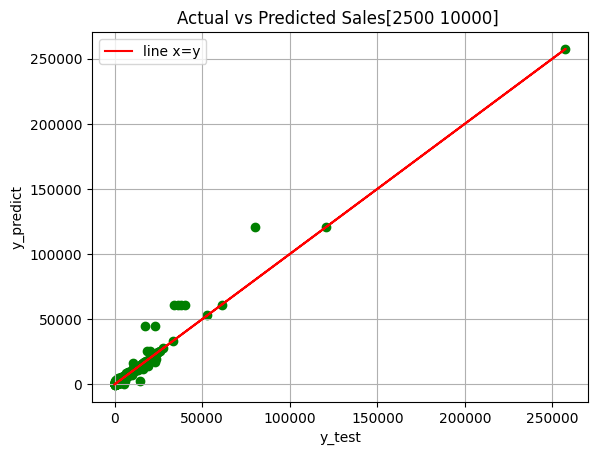

In [111]:

features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
X = df.loc[: ,features]
y = df.loc[:,'total_sold']
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.9)
y_predict=TreeDecision_3.prediction(X_test)
fig=plt.figure()
plt.scatter(y_test.sort_index(), y_predict.sort_index(), color='green')
plt.plot(y_test.sort_index(), y_test.sort_index(), color='red',label='line x=y')
plt.xlabel('y_test',)
plt.ylabel('y_predict')
plt.title('Actual vs Predicted Sales' f'[{listdown[lisup.index(i)]} {i}] ')
plt.legend()
plt.grid(True)

In [109]:
y_test.sort_index()

0          3.0
1        242.0
2          4.0
4         84.0
5         13.0
         ...  
14364      1.0
14365    101.0
14366     88.0
14367    723.0
14368    880.0
Name: total_sold, Length: 12933, dtype: float64

In [110]:
y_predict.sort_index()

,prediction
index,
0,2.326353
1,140.789948
2,-5.660143
4,92.773804
5,18.662701
...,...
14364,0.797644
14365,145.938675
14366,68.054710
